#### Современные нейросетевые технологии

* EDA (с картинками)
* Наличие персептрона
* Добавление новых признаков
* Проверка результата с помощью Catboost или любого другого классификатора
* Выводы
* Рекомендации

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('german_credit_data.csv', index_col=0)
print(df.shape)
df.head()

(1000, 9)


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


## EDA

In [ ]:
# #, Уникальных значений
df.nunique()

Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
dtype: int64

In [ ]:
# %, Пропущенных значений
round(df.isnull().sum()/df.shape[0], 2).apply(lambda x: str(x*100)+'%')

Age                  0.0%
Sex                  0.0%
Job                  0.0%
Housing              0.0%
Saving accounts     18.0%
Checking account    39.0%
Credit amount        0.0%
Duration             0.0%
Purpose              0.0%
dtype: object

In [ ]:
# Заполняем пропущенные значения
for col in ['Saving accounts', 'Checking account']:
    df[col] = df[col].fillna('Missing')

In [ ]:
# Определяем таргет - bad, если сумма кредита меньше средней по выборке - прогнозируем плохих клиентов (с низкой суммой кредита) 
mean_cr_am = df['Credit amount'].mean()
print(f'Средняя сумма кредита = {mean_cr_am}')
df.loc[df['Credit amount']<mean_cr_am, 'Target'] = 1
df['Target'] = df['Target'].fillna(0)

Средняя сумма кредита = 3271.258


1.0    658
0.0    342
Name: Target, dtype: int64

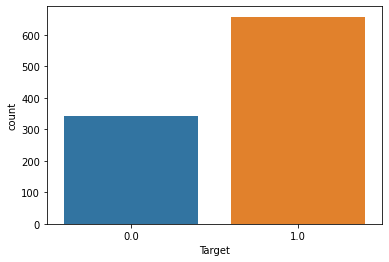

In [ ]:
# Определяем баланс классов
sns.countplot(df['Target'])
df['Target'].value_counts()

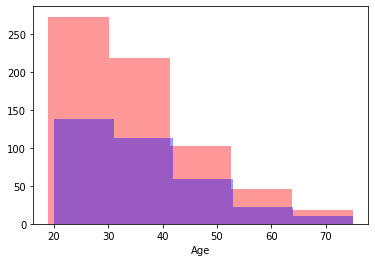

In [ ]:
# Распределение возраста в зависимости от таргета
sns.distplot(df['Age'].loc[df['Target']==1], color='red', bins=5, kde=False)
sns.distplot(df['Age'].loc[df['Target']==0], color='blue', bins=5, kde=False);

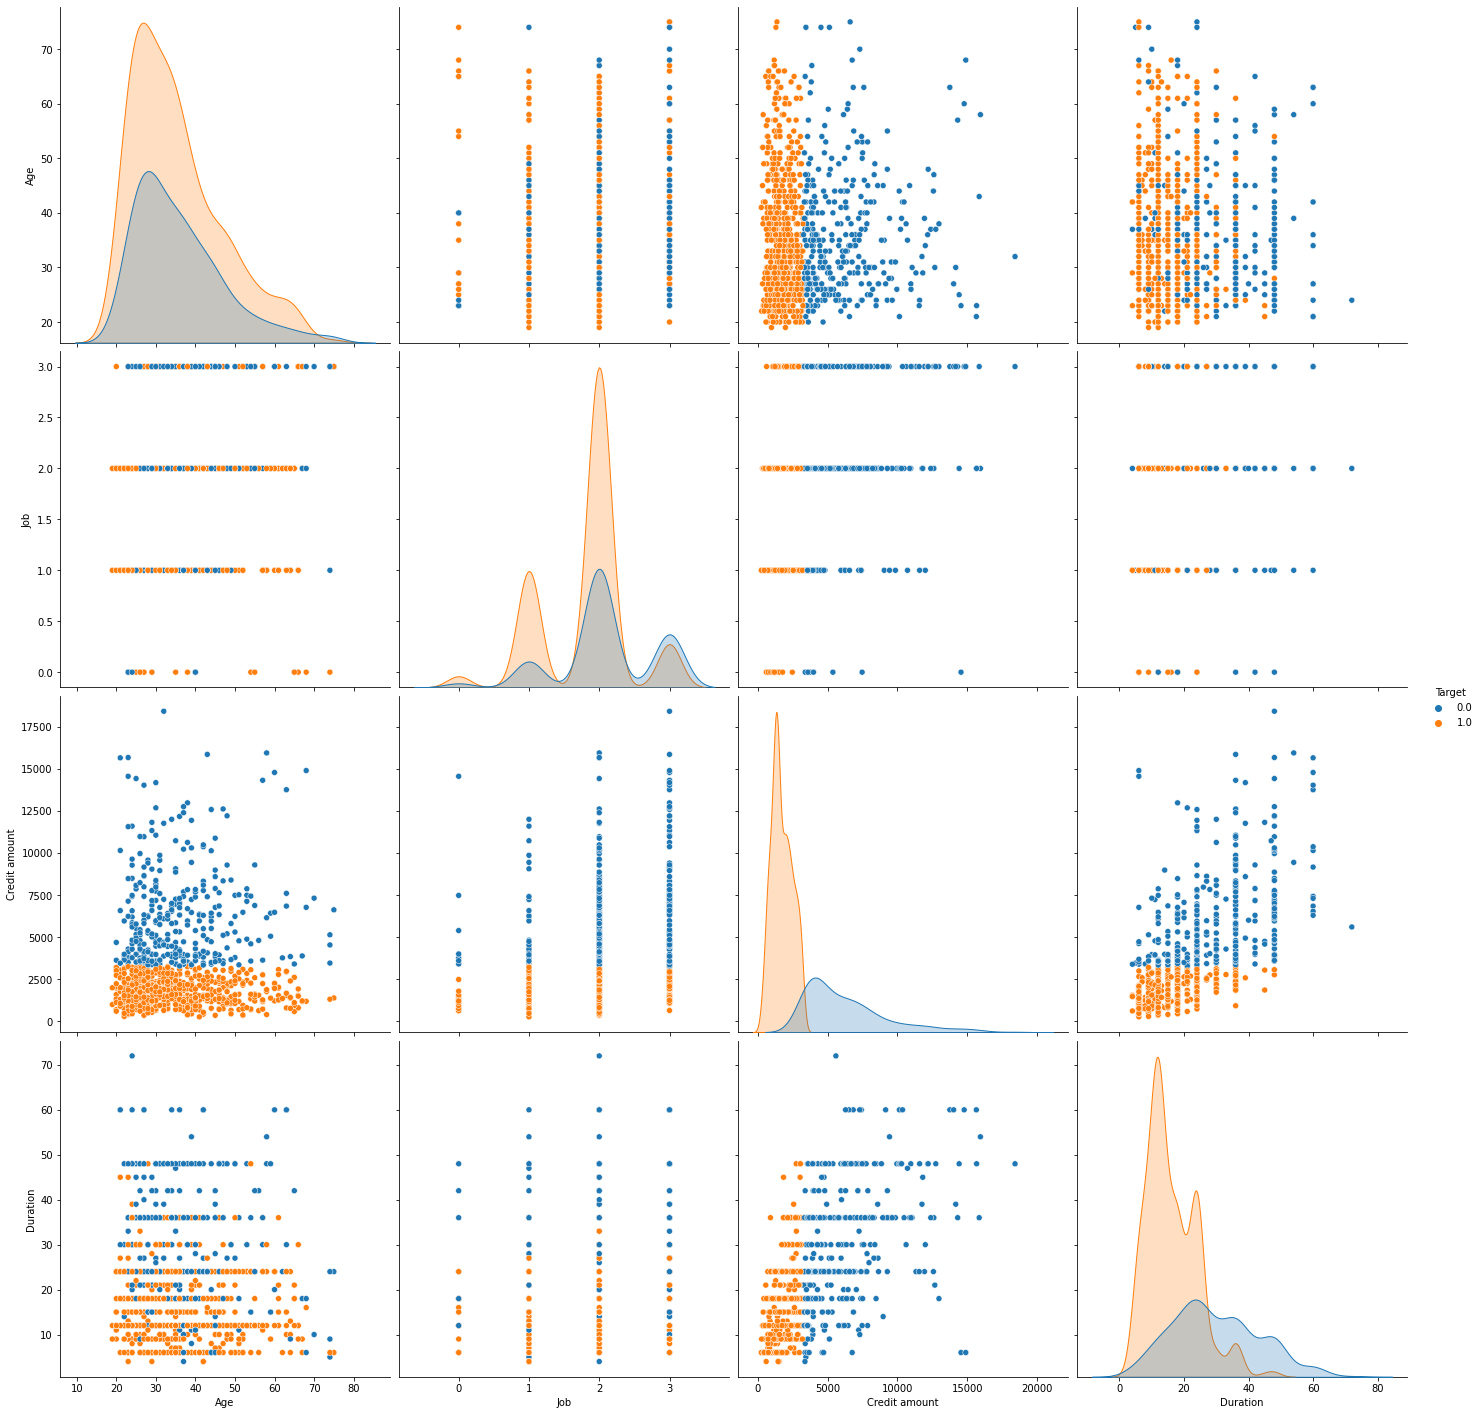

In [ ]:
sns.pairplot(df, hue='Target', size=5)

In [ ]:
# Удаляем из выборки CreditAmount - скрытый таргет
df.drop(['Credit amount'], axis=1, inplace=True)

In [ ]:
# Задаем список категориальных колонок
target_col = ['Target']
cat_col = [i for i in df.columns if df[i].dtypes=='object']
num_col = [i for i in df.columns if i not in cat_col+target_col]
print(f'Список с таргет-фичей: {target_col}')
print(f'Список с категориальными фичами: {cat_col}')
print(f'Список с непрерывными фичами: {num_col}')

Список с таргет-фичей: ['Target']
Список с категориальными фичами: ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
Список с непрерывными фичами: ['Age', 'Job', 'Duration']


In [ ]:
df_copy_for_catboost = df.copy()

In [ ]:
# Проверяем гипотезу о категориальности фичей
pd.DataFrame(df[cat_col].nunique()).reset_index().rename(columns={0:'# уникальных значений', 'index':'Фича'})

,Фича,# уникальных значений
0,Sex,2
1,Housing,3
2,Saving accounts,5
3,Checking account,4
4,Purpose,8


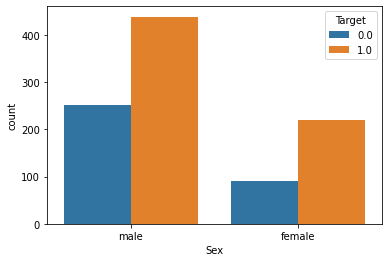

In [ ]:
# Зависимость таргета от пола
sns.countplot(x='Sex', hue='Target', data=df);

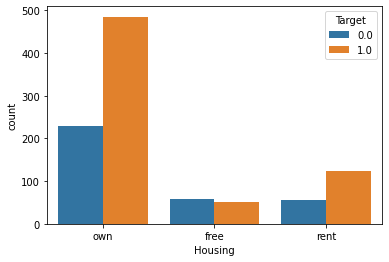

In [ ]:
# Зависимость таргета от типа владения недвижимостью
sns.countplot(x='Housing', hue='Target', data=df);

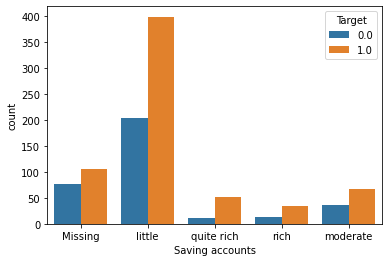

In [ ]:
# Зависимость таргета от наличия сберегательных счетов
sns.countplot(x='Saving accounts', hue='Target', data=df);

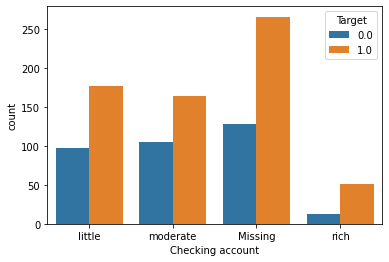

In [ ]:
# Зависимость таргета от количества проверок
sns.countplot(x='Checking account', hue='Target', data=df);

<AxesSubplot:xlabel='Purpose', ylabel='count'>

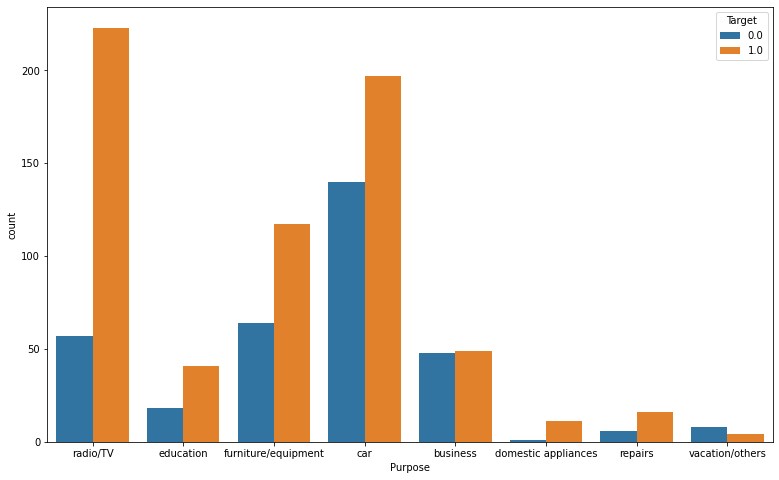

In [ ]:
# Зависимость таргета от цели кредита
dims = (13, 8)
fig, ax = plt.subplots(figsize=dims)
sns.countplot(x='Purpose', hue='Target', ax=ax, data=df)

In [ ]:
# Выполняем LabelEncoding для категориальных фичей на всем массиве данных
from sklearn.preprocessing import LabelEncoder

# Создаем словарь для хранения LE для каждой колонки
from collections import defaultdict
d = defaultdict(LabelEncoder)

# Кодируем фичи
df[cat_col] = df[cat_col].apply(lambda x: d[x.name].fit_transform(x))

# Для обратной трансформации
# df[cat_col].apply(lambda x: d[x.name].inverse_transform(x))

# Для кодирования категориальных фичей в будущем
# df[cat_col].apply(lambda x: d[x.name].transform(x))

# Проверяем LabelEcoding
df.dtypes

Age                   int64
Sex                   int64
Job                   int64
Housing               int64
Saving accounts       int64
Checking account      int64
Duration              int64
Purpose               int64
Target              float64
dtype: object

In [ ]:
# Работаем с выбросами
for col in df.columns:
    if col=='Target':
        pass
    else:
        perc_99 = round(np.percentile(df[col], 99), 0)
        perc_1 = round(np.percentile(df[col], 1), 0)
        df.loc[df[col]>=perc_99, col] = perc_99
        df.loc[df[col]<=perc_1, col] = perc_1
        print(f'{col} заменяем выбросы снизу {perc_1}, сверху {perc_99}')

Age заменяем выбросы снизу 20.0, сверху 67.0
Sex заменяем выбросы снизу 0.0, сверху 1.0
Job заменяем выбросы снизу 0.0, сверху 3.0
Housing заменяем выбросы снизу 0.0, сверху 2.0
Saving accounts заменяем выбросы снизу 0.0, сверху 4.0
Checking account заменяем выбросы снизу 0.0, сверху 3.0
Duration заменяем выбросы снизу 6.0, сверху 60.0
Purpose заменяем выбросы снизу 0.0, сверху 7.0


In [ ]:
df_copy_for_add_var = df.copy()

In [ ]:
# Создаем dummy переменные
labels = list(cat_col)
for col in labels:
    df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
    df.drop(col, axis=1, inplace=True)

In [ ]:
# Делим на train-test
y = df['Target'].values
X = df.drop(['Target'], axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=40)

In [ ]:
print(X_train.shape, X_test.shape)

(750, 25) (250, 25)


In [ ]:
print(y_train.shape, y_test.shape)

(750,) (250,)


In [ ]:
# Выполняем масштабирование
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Baseline - логистическая регрессия

In [ ]:
# Используем baseline модель - логистическую регрессию
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

parameters = {'C':[0.001, 0.01, 0.1, 0.5, 1, 5, 10], 'class_weight':[{0:0.2, 1:0.8}, {0:1, 1:0.7}, {0:1.2, 1:0.7}, {0:1, 1:0.85}, {0:1, 1:0.9}]}
clf = LogisticRegression(solver = 'lbfgs', max_iter = 1000, random_state=42, n_jobs=-1, penalty='l2')
gs = GridSearchCV(clf, parameters, scoring='accuracy')
gs.fit(X_train, y_train)

best_estim = gs.best_estimator_
best_param = gs.best_params_
best_acc = gs.best_score_

print(f'Лучший accuracy = {best_acc}')
print(f'Лучшие параметры = {best_param}' )

Лучший accuracy = 0.7813333333333334
Лучшие параметры = {'C': 0.01, 'class_weight': {0: 1, 1: 0.9}}


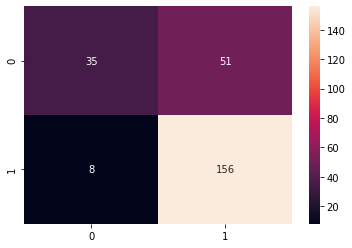

In [ ]:
# Строим confusion matrix

from sklearn.metrics import confusion_matrix
y_pred = best_estim.predict(X_test)
y_val = y_test

sns.heatmap(confusion_matrix(y_val,y_pred), annot=True, fmt='.5g') ;

## Baseline 2 - перспетрон

In [ ]:
from keras.models import Sequential
from keras import regularizers
from keras import optimizers
from keras.layers import Dense, Dropout

In [ ]:
# Определим опитимизатор 
sgd = optimizers.SGD(lr=0.03, decay=0, momentum=0.9, nesterov=False)

model = Sequential()
model.add(Dense(units=50, activation='tanh', input_dim=25))
model.add(Dropout(0.35))
model.add(Dense(units=1, activation='sigmoid'))

In [ ]:
# Компилляция модели
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [ ]:
# Обучение модели
h = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=20)

Epoch 1/50
38/38 [==============================] - 0s 3ms/step - loss: 0.2710 - accuracy: 0.8787 - val_loss: 0.6048 - val_accuracy: 0.7760
Epoch 2/50
38/38 [==============================] - 0s 2ms/step - loss: 0.2846 - accuracy: 0.8907 - val_loss: 0.6050 - val_accuracy: 0.7800
Epoch 3/50
38/38 [==============================] - 0s 2ms/step - loss: 0.2689 - accuracy: 0.8787 - val_loss: 0.6036 - val_accuracy: 0.7800
Epoch 4/50
38/38 [==============================] - 0s 2ms/step - loss: 0.2998 - accuracy: 0.8653 - val_loss: 0.5988 - val_accuracy: 0.7880
Epoch 5/50
38/38 [==============================] - 0s 2ms/step - loss: 0.2981 - accuracy: 0.8693 - val_loss: 0.6071 - val_accuracy: 0.7800
Epoch 6/50
38/38 [==============================] - 0s 2ms/step - loss: 0.2926 - accuracy: 0.8813 - val_loss: 0.6016 - val_accuracy: 0.7720
Epoch 7/50
38/38 [==============================] - 0s 2ms/step - loss: 0.3057 - accuracy: 0.8573 - val_loss: 0.5976 - val_accuracy: 0.7760
Epoch 8/50
38/38 [==

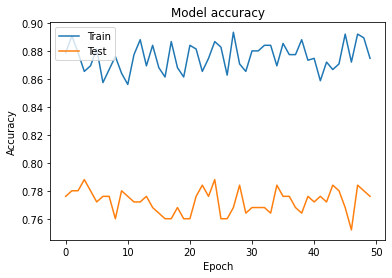

In [ ]:
# Plot training & validation accuracy values
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy']) # для тренировочного 
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

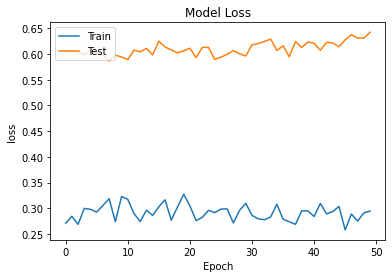

In [ ]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss']) # для тренировочного 
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


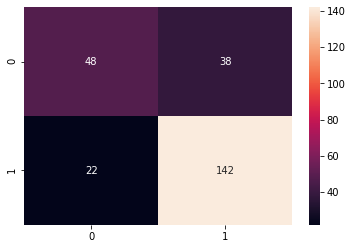

In [ ]:
# Строим confusion matrix

from sklearn.metrics import confusion_matrix
y_pred = model.predict_classes(X_test)
y_val = y_test

sns.heatmap(confusion_matrix(y_val,y_pred), annot=True, fmt='.5g');

### Создаем дополнительные фичи

In [ ]:
df_work = df_copy_for_add_var.copy()
print(df_work.shape)
df_work.head()

(1000, 9)


,Age,Sex,Job,Housing,Saving accounts,Checking account,Duration,Purpose,Target
0,67.0,1.0,2.0,1.0,0.0,1.0,6.0,5.0,1.0
1,22.0,0.0,2.0,1.0,1.0,2.0,48.0,5.0,0.0
2,49.0,1.0,1.0,1.0,1.0,0.0,12.0,3.0,1.0
3,45.0,1.0,2.0,0.0,1.0,1.0,42.0,4.0,0.0
4,53.0,1.0,2.0,0.0,1.0,1.0,24.0,1.0,0.0


In [ ]:
df_work.nunique()

Age                 48
Sex                  2
Job                  4
Housing              3
Saving accounts      5
Checking account     4
Duration            30
Purpose              8
Target               2
dtype: int64

<AxesSubplot:>

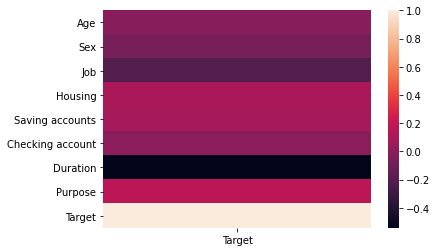

In [ ]:
# Смотрим корреляции признаков с таргетом
sns.heatmap(df_work.corr()[['Target']])

In [ ]:
# Создаем новые фичи - комбинации текущих
df_work['Sex_Job'] = df_work['Sex'] * df_work['Job']
df_work['Sex_Housing'] = df_work['Sex'] * df_work['Housing']
df_work['Sex_Purpose'] = df_work['Sex'] * df_work['Purpose']
df_work['Sex_Saving accounts'] = df_work['Sex'] * df_work['Saving accounts']
df_work['Sex_Checking account'] = df_work['Sex'] * df_work['Checking account']

df_work['Job_Housing'] = df_work['Job'] * df_work['Housing']
df_work['Job_Purpose'] = df_work['Job'] * df_work['Purpose']
df_work['Job_Saving accounts'] = df_work['Job'] * df_work['Saving accounts']
df_work['Job_Checking account'] = df_work['Job'] * df_work['Checking account']

In [ ]:
df = df_work.copy()

In [ ]:
round(df.describe(), 2)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Duration,Purpose,Target,Sex_Job,Sex_Housing,Sex_Purpose,Sex_Saving accounts,Sex_Checking account,Job_Housing,Job_Purpose,Job_Saving accounts,Job_Checking account
count,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.0,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00
mean,35.50,0.69,1.90,1.07,1.19,1.00,20.9,2.88,0.66,1.34,0.68,1.93,0.81,0.68,2.00,5.45,2.24,1.87
std,11.22,0.46,0.65,0.53,0.97,0.96,12.0,1.98,0.47,1.04,0.62,2.12,0.96,0.92,1.24,4.33,2.02,2.03
min,20.00,0.00,0.00,0.00,0.00,0.00,6.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,27.00,0.00,2.00,1.00,1.00,0.00,12.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2.00,1.00,0.00
50%,33.00,1.00,2.00,1.00,1.00,1.00,18.0,3.00,1.00,2.00,1.00,1.00,1.00,0.00,2.00,4.00,2.00,2.00
75%,42.00,1.00,2.00,1.00,1.00,2.00,24.0,5.00,1.00,2.00,1.00,4.00,1.00,1.00,2.00,10.00,3.00,3.00
max,67.00,1.00,3.00,2.00,4.00,3.00,60.0,7.00,1.00,3.00,2.00,7.00,4.00,3.00,6.00,21.00,12.00,9.00


In [ ]:
# Создаем dummy переменные
labels = list(cat_col)
for col in labels:
    df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
    df.drop(col, axis=1, inplace=True)

In [ ]:
# Делим на train-test
y = df['Target'].values
X = df.drop(['Target'], axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=40)

In [ ]:
# Выполняем масштабирование
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
print(X_train.shape)

(750, 34)


## Baseline 2 - перспетрон v2 (с новыми фичами)

In [ ]:
# Определим опитимизатор 
sgd = optimizers.SGD(lr=0.03, decay=0, momentum=0.9, nesterov=False)

model = Sequential()
model.add(Dense(units=50, activation='tanh', input_dim=34))
model.add(Dropout(0.35))
model.add(Dense(units=1, activation='sigmoid'))

In [ ]:
# Компилляция модели
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [ ]:
# Обучение модели
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=500, batch_size=128)

Epoch 1/500
6/6 [==============================] - 0s 23ms/step - loss: 0.8422 - accuracy: 0.5107 - val_loss: 0.6918 - val_accuracy: 0.5760
Epoch 2/500
6/6 [==============================] - 0s 5ms/step - loss: 0.6624 - accuracy: 0.6293 - val_loss: 0.5618 - val_accuracy: 0.7040
Epoch 3/500
6/6 [==============================] - 0s 5ms/step - loss: 0.5518 - accuracy: 0.7227 - val_loss: 0.5058 - val_accuracy: 0.7480
Epoch 4/500
6/6 [==============================] - 0s 5ms/step - loss: 0.5006 - accuracy: 0.7560 - val_loss: 0.4757 - val_accuracy: 0.7800
Epoch 5/500
6/6 [==============================] - 0s 6ms/step - loss: 0.4926 - accuracy: 0.7667 - val_loss: 0.4644 - val_accuracy: 0.7720
Epoch 6/500
6/6 [==============================] - 0s 5ms/step - loss: 0.4812 - accuracy: 0.7720 - val_loss: 0.4643 - val_accuracy: 0.7640
Epoch 7/500
6/6 [==============================] - 0s 5ms/step - loss: 0.4816 - accuracy: 0.7893 - val_loss: 0.4666 - val_accuracy: 0.7680
Epoch 8/500
6/6 [=========

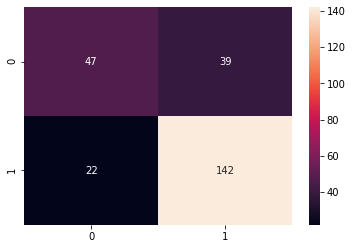

In [ ]:
# Строим confusion matrix

from sklearn.metrics import confusion_matrix
y_pred = model.predict_classes(X_test)
y_val = y_test

sns.heatmap(confusion_matrix(y_val,y_pred), annot=True, fmt='.5g');

## Baseline - логистическая регрессия v2 (с новыми фичами)

In [ ]:
# Используем baseline модель - логистическую регрессию
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

parameters = {'C':[0.001, 0.01, 0.1, 0.5, 1, 5, 10], 'class_weight':[{0:0.2, 1:0.8}, {0:1, 1:0.7}, {0:1.2, 1:0.7}, {0:1, 1:0.85}, {0:1, 1:0.9}]}
clf = LogisticRegression(solver = 'lbfgs', max_iter = 1000, random_state=42, n_jobs=-1, penalty='l2')
gs = GridSearchCV(clf, parameters, scoring='accuracy')
gs.fit(X_train, y_train)

best_estim = gs.best_estimator_
best_param = gs.best_params_
best_acc = gs.best_score_

print(f'Лучший accuracy = {best_acc}')
print(f'Лучшие параметры = {best_param}' )

Лучший accuracy = 0.78
Лучшие параметры = {'C': 0.01, 'class_weight': {0: 1, 1: 0.85}}


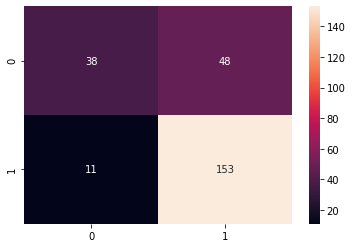

In [ ]:
# Строим confusion matrix

from sklearn.metrics import confusion_matrix
y_pred = best_estim.predict(X_test)
y_val = y_test

sns.heatmap(confusion_matrix(y_val,y_pred), annot=True, fmt='.5g') ;

### Проверка результата с помощью Catboost

In [ ]:
from catboost import CatBoostClassifier, Pool
train_data = Pool(data=X_train,
                  label=y_train)
test_data = Pool(data=X_test,
                  label=y_test)

In [ ]:
model = CatBoostClassifier(iterations=100,
                          learning_rate=1,
                           l2_leaf_reg=0.01,
                          eval_metric='Accuracy')
model.fit(train_data,eval_set = test_data)

0:	learn: 0.7973333	test: 0.7880000	best: 0.7880000 (0)	total: 7.54ms	remaining: 746ms
1:	learn: 0.8013333	test: 0.7680000	best: 0.7880000 (0)	total: 12.6ms	remaining: 615ms
2:	learn: 0.8253333	test: 0.7560000	best: 0.7880000 (0)	total: 14.6ms	remaining: 472ms
3:	learn: 0.8386667	test: 0.7400000	best: 0.7880000 (0)	total: 17.6ms	remaining: 422ms
4:	learn: 0.8560000	test: 0.7480000	best: 0.7880000 (0)	total: 23.7ms	remaining: 450ms
5:	learn: 0.8680000	test: 0.7000000	best: 0.7880000 (0)	total: 23.9ms	remaining: 375ms
6:	learn: 0.8760000	test: 0.7080000	best: 0.7880000 (0)	total: 28.5ms	remaining: 379ms
7:	learn: 0.8866667	test: 0.7080000	best: 0.7880000 (0)	total: 32.6ms	remaining: 374ms
8:	learn: 0.8893333	test: 0.7200000	best: 0.7880000 (0)	total: 40.3ms	remaining: 407ms
9:	learn: 0.9106667	test: 0.7280000	best: 0.7880000 (0)	total: 45.9ms	remaining: 413ms
10:	learn: 0.9160000	test: 0.7160000	best: 0.7880000 (0)	total: 50.6ms	remaining: 409ms
11:	learn: 0.9253333	test: 0.7040000	best:

In [ ]:
pd.DataFrame({'Модель' : ['Baseline LR', 'Baseline NN', 'LR v2', 'NN v2', 'Catboost v2'], 'Accuracy':[0.78, 0.85, 0.78, 0.87, 0.78]})

,Модель,Accuracy
0,Baseline LR,0.78
1,Baseline NN,0.85
2,LR v2,0.78
3,NN v2,0.87
4,Catboost v2,0.78
